In [1]:
from os.path import join
import numpy as np
import matplotlib.pyplot as plt

import tidy3d.web as web

import tidy3d as td
import tidy3D_backend
from tidy3d.plugins.resonance import ResonanceFinder
from tidy3d import web

%load_ext autoreload
%autoreload 2

In [52]:
wavelength_range = np.linspace(0.5, 0.55, 50)
freq0 = td.C_0/np.mean(wavelength_range)
freq_range = td.C_0/wavelength_range

Nx, Ny, alattice, hole_radius, slab_thickness, refractive_index, x_shift = tidy3D_backend.L3_params_520()
slab_thickness = 0.22471
hole_radius = 0.065

def make_simulation(index, sigma_r, sigma_xy):

    x_pos, y_pos = tidy3D_backend.phc_holes_array(Nx, Ny, alattice, "L3")
    x_pos[0] = x_pos[0] + x_shift

    file_name = rf'./weights_520_12.08.2024/param_history/{weights_name}_param_history.npy' # type: ignore
    param_history = np.load(file_name, allow_pickle=True)
    param_history = param_history.reshape(param_history.shape[0]//(2*len(y_pos)), 2*len(y_pos))
    parameters = param_history[-1]

    dx = parameters[0: len(x_pos)] * alattice
    dy = parameters[len(x_pos):] * alattice

    Nx_final, Ny_final = 32, 32
    x_pos, y_pos, dx, dy = tidy3D_backend.convert_phc_size(Nx, Ny, Nx_final, Ny_final, alattice, dx, dy)
    x_pos[0] = x_pos[0] + x_shift

    
    if(index != 0):
        # Make gaussian distributed noise for the hole positions and radii
        noise_arrays = tidy3D_backend.return_noise_arrays(sigma_xy, sigma_r, x_pos)
    else:
        # Adding one un-perturbed cavity in the mix for comparison
        noise_arrays = tidy3D_backend.return_noise_arrays(0, 0, x_pos)
        
    slab, holes = tidy3D_backend.get_noisy_phc(Nx_final, Ny_final, x_pos, y_pos, alattice, hole_radius, slab_thickness, slab_medium, dx, dy, noise_arrays)
    
    # Initialize dipole source
    source = tidy3D_backend.return_dipole_source(freq0, fwidth = 2e14, center_location = [0, 0, 0], polarization = "Ey")

    # Initialize time series monitor for Q analysis
    time_series_monitor = tidy3D_backend.get_time_series_monitor(t_start = 2e-13, center = [0, 0, 0], size = [0, 0, 0], name = "time_series")

    # Initialize far-field monitor
    far_field_monitor = tidy3D_backend.get_far_field_monitor(slab_thickness, freq_range, t_start = 2e-13, width = 2e-14, name = "far_field monitor")

    # Initialize the grid for meshing
    grid_spec = tidy3D_backend.define_mesh(alattice, steps_per_unit_length = 15)

    # Simulation run time (s)
    run_time = 3e-12

    # Simulation domain size (micron)
    size_z = 2
    sim_size = [(Nx_final + 2) * alattice, (Ny_final + 2) * alattice * np.sqrt(3) / 2, size_z]

    # Create simulation object
    sim = td.Simulation(
        size=sim_size,
        grid_spec=grid_spec,
        structures=[slab, holes],
        sources=[source],
        monitors=[time_series_monitor, far_field_monitor],
        run_time=run_time,
        boundary_spec=td.BoundarySpec.all_sides(boundary=td.PML()),
        symmetry=(0, 0, 1), # Removed symmetry condition in X and Y becasue of added noise
        shutoff=0,
    )

    fig, ax = plt.subplots(1, 2, figsize=(10, 4))
    sim.plot(z=0, ax=ax[0])
    sim.plot(y=0, ax=ax[1])
    plt.show()
    
    return sim, noise_arrays

In [48]:
# weights_name = 'L3_520nm_weights_step_size_690_gmax_2_kpoints_1_loss_V2_Q_target_10e5_phc_size_16_ffgauss_0_scale_10e0'        # D2
# weights_name = 'L3_520nm_weights_step_size_300_gmax_2_kpoints_2_loss_V2_Q_target_10e5_phc_size_16_ffgauss_4_scale_10e0'          # G2
weights_name = 'L3_520nm_weights_step_size_100_grad_approx_gmax_2_kpoints_2_loss_V2_Q_target_10e4_phc_size_16_ffgauss_1_scale_10e0'  # G1
# weights_name = 'L3_520nm_weights_step_size_500_gmax_2_kpoints_1_loss_V2_Q_target_10e5_phc_size_16_ffgauss_0_random_radii_3_ratio_0.97_sigma_r_2.0_sigma_xy_0.0'
# weights_name = 'L3_520nm_weights_step_size_100_gmax_2_kpoints_1_loss_V2_Q_target_10e5_phc_size_16_ffgauss_0_random_radii_3_sigma_0.001'
# weights_name = 'L3_520nm_weights_step_size_100_gmax_2_kpoints_1_loss_V2_Q_target_10e5_phc_size_16_ffgauss_0_3_radii'
# weights_name = 'L3_520nm_weights_step_size_100_gmax_2.5_kpoints_1_loss_V2_Q_target_10e5_phc_size_16_ffgauss_0_random_radii_3_ratio_0.97_sigma_r_5.0_sigma_xy_0.0'
# weights_name = 'L3_520nm_weights_step_size_50_gmax_2.5_kpoints_1_loss_V2_Q_target_10e5_phc_size_16_ffgauss_0_random_radii_1_ratio_0_sigma_r_0.0_sigma_xy_2.5'

# Materials - air and silicon
air = td.Medium()
slab_medium = td.Medium(permittivity=refractive_index**2)

index = 0 , sigma_r = 0.0015 , sigma_xy = 0


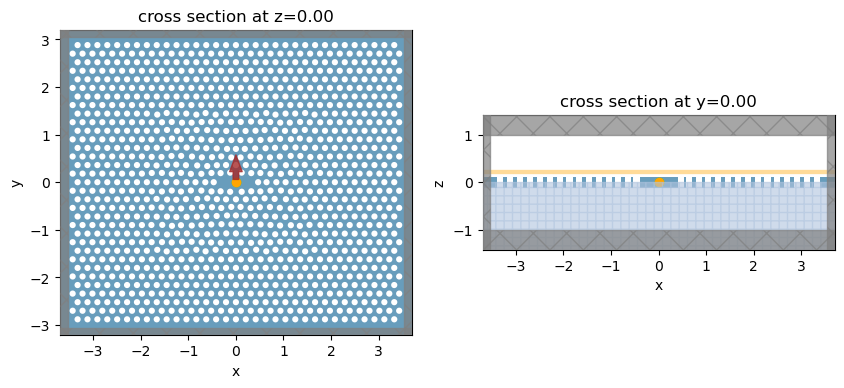

Output()

17:27:48 Eastern Daylight Time Started working on Batch containing 1 tasks.

17:27:50 Eastern Daylight Time Maximum FlexCredit cost: 0.594 for the whole     
                               batch.

                               Use 'Batch.real_cost()' to get the billed        
                               FlexCredit cost after the Batch has completed.

Output()

17:29:43 Eastern Daylight Time Batch complete.

Output()

17:29:51 Eastern Daylight Time Total billed flex credit cost: 0.594.

0.5944126428055385


In [53]:
index_array = np.arange(1)
# sigma_r_array = np.asarray([0.001])
# sigma_xy_array = np.asarray([])
sigma_r = 1.5e-3
sigma_xy = 0

# submit all jobs
noise_analysis_simulation = {}

data_dict = {'sigma_xy': sigma_xy, 'sigma_r': sigma_r, 'noise_arrays': [], 
             'far_field': [], 'directionality': [], 'quality_factor': [], 
             'wavelength': []}

# for sigma in sigma_array:
for index in index_array:
  name = 'index = ' + str(index) + ' , sigma_r = ' + str(sigma_r) + ' , sigma_xy = ' + str(sigma_xy) 
  print (name)
  flag = True
  while flag:
    # Try making one simulation until it works
    # Possible error is overlaping of holes when noise is added
    try:
      noise_analysis_simulation[name], noise_array = make_simulation(index, sigma_r, sigma_xy)
      flag = False
      data_dict['noise_arrays'].append(noise_array)
    except:
      pass
    
# Upload batch data and run
batch = web.Batch(simulations=noise_analysis_simulation, verbose=True)
batch_results = batch.run(path_dir="data")

# Save batch data info
# batch_results.to_file(rf'./L3_520nm_noise analysis/Tidy3D analysis/{weights_name}_modified_noise_analysis_sigma_r={sigma_r*1e3}_sigmaxy={sigma_xy*1e3}_batch_data.json')
print (batch.real_cost())

In [50]:

wavelength_range[index]

0.5

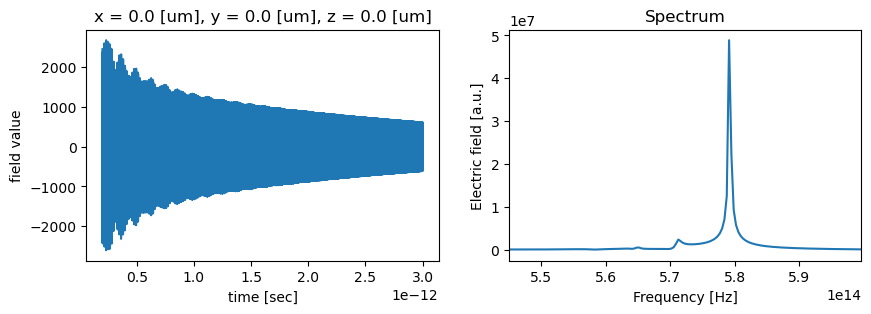

                     decay            Q   amplitude     phase     error
freq                                                                   
5.710012e+14  2.260038e+12   793.726980  124.868022 -2.847347  0.007153
5.790316e+14  3.559693e+11  5110.219696  823.564807 -0.239235  0.001892
6.401308e+14  3.647697e+12   551.315057  488.019221 -0.144703  0.008570
Resonant wavelength =  517.75 nm, Quality factor =  5110.219696178706
Closest wavelength =  517.35 nm


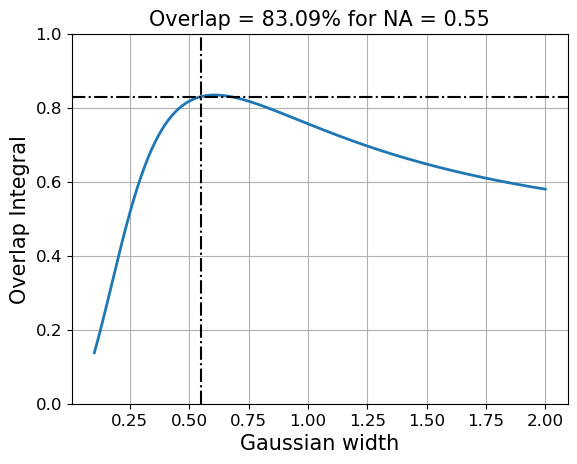

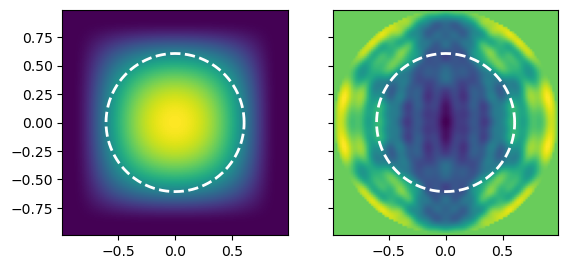

Run: index = 0 , sigma_r = 0.0015 , sigma_xy = 0, Q: 5110.219696178706, Dir: 0.8308532067182937, wavelength: 517.75


In [54]:
quality_factory_array = []
directionality_array = []

for idx, (task_name, sim_data) in enumerate(batch_results.items()):
    index, quality_factor, resonant_wavelength = tidy3D_backend.analyse_time_monitor_data(sim_data, freq_range, freq_window = (freq_range[-1], freq_range[0]), plot_bool = True, print_data=True)
    quality_factory_array.append(quality_factor)
    
    print("Resonant wavelength = ", resonant_wavelength, "nm, Quality factor = ", quality_factor)
    print("Closest wavelength = ", np.round(tidy3D_backend.convert_freq_to_wavelength(freq_range[index])*1000,2), "nm")

    # far_field = np.sqrt(np.squeeze(np.abs(sim_data["far_field monitor"].fields_cartesian.Ex[:, :, :, index])**2).T + \
    #             np.squeeze(np.abs(sim_data["far_field monitor"].fields_cartesian.Ey[:, :, :, index])**2).T + \
    #             np.squeeze(np.abs(sim_data["far_field monitor"].fields_cartesian.Ez[:, :, :, index])**2).T)
    
    Ey_angle, Ey_real = tidy3D_backend.get_real_part_field(sim_data["far_field monitor"].fields_cartesian.Ey[:, :, :, index].T)
    
    # overlap_integral, width_max = tidy3D_backend.calculate_directionality(far_field, ff_type = 'directional', NA = 0.5, bool_plot = False)
    overlap_integral = tidy3D_backend.calculate_directionality(Ey_real, ff_type = 'gaussian', NA = 0.55, bool_plot = True)
    
    print (f"Run: {task_name}, Q: {quality_factor}, Dir: {overlap_integral}, wavelength: {resonant_wavelength}")
    data_dict['quality_factor'].append(quality_factor)
    data_dict['far_field'].append(Ey_real)
    data_dict['directionality'].append(overlap_integral)
    data_dict['wavelength'].append(resonant_wavelength)
    
# np.save(rf'./L3_520nm_noise analysis/Tidy3D analysis/{weights_name}_modified_noise_analysis_sigma_r={sigma_r}_sigmaxy={sigma_xy}.npy', data_dict)

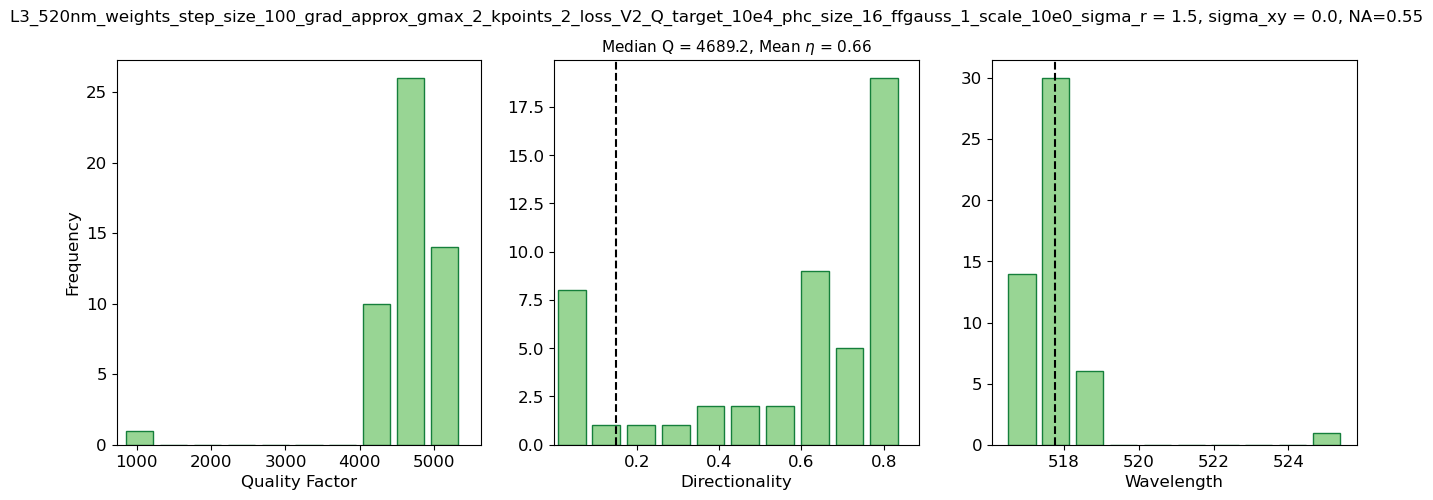

In [21]:
Q_factor_array = np.asarray(data_dict['quality_factor'])
dir_array = np.asarray(data_dict['directionality'])
wavelength_array = np.asarray(data_dict['wavelength'])

Loss_function = (np.pi/4 - np.arctan(Q_factor_array/1e5))**2 + (1 - dir_array)**2

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 5))
plt.rcParams.update({'font.size': 12})

cmap = plt.colormaps.get_cmap('Greens')

ax1.hist(Q_factor_array, bins = 10, facecolor = cmap(0.4), edgecolor = cmap(0.8), rwidth = 0.8)
ax1.set_ylabel('Frequency')
ax1.set_xlabel('Quality Factor')
# ax1.axvline(x = Q_factor_array[0], linestyle = '--', color = 'k')
ax1.set_xlim(np.min(Q_factor_array)*0.9, np.max(Q_factor_array)*1.05)
# ax1.axvline(x = Q_factor_array[0], color = 'k', linestyle = '--')

ax2.hist(dir_array[1:], bins = 10, facecolor = cmap(0.4), edgecolor = cmap(0.8), rwidth = 0.8)
ax2.set_xlim(0.0, 1.0)
ax2.set_xlabel('Directionality')
ax2.set_xlim(np.min(directionality_array)*0.95, np.max(directionality_array)*1.05)
ax2.axvline(x = dir_array[0], color = 'k', linestyle = '--')
ax2.set_title(f'Median Q = {np.round(np.median(Q_factor_array[1:]),1)}, Mean $\eta$ = {np.round(np.median(directionality_array[1:]), 2)}', fontsize = 11)

ax3.hist(wavelength_array, bins = 10, facecolor = cmap(0.4), edgecolor = cmap(0.8), rwidth = 0.8)
ax3.axvline(wavelength_array[0], color = 'k', linestyle = '--')
ax3.set_xlabel('Wavelength')

plt.suptitle(f'{weights_name}_sigma_r = {sigma_r*1e3}, sigma_xy = {sigma_xy*1e3}, NA=0.55', fontsize = 12)
plt.savefig(f'./L3_520nm_noise analysis/Tidy3D analysis/Figures/{weights_name}_modified_sigma_r={sigma_r}_sigma_xy={sigma_xy}_histogram.png')
plt.show()

In [28]:
slope = (1/np.mean(Q_factor_array[1:]) - 1/(Q_factor_array[0]))*(0.208/sigma_r)**2
print(slope)

0.34621026040880976


In [30]:
(1/Q_factor_array[0] + slope*(1.5e-3/0.208)**2)**-1

15118.036767936519

In [18]:
wavelength_array[0]

517.06